In [1]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
import os
os.sys.path.extend(['../evaluation'])
from evaluate import model_preprocessed_filepath
import glob
from matplotlib import pyplot as plt
import math
%matplotlib inline

chencherry = SmoothingFunction().method1

In [2]:
def get_scores(filepath, subset='all-cat'):
    
    references_files = [f'../evaluation/references/{subset}_reference{i}.lex' for i in range(3)]
    hypothesis_file = filepath

    scores = []
    hypothesis = []
    references = []

    with open(references_files[0], 'r', encoding='utf-8') as ref0,\
         open(references_files[1], 'r', encoding='utf-8') as ref1,\
         open(references_files[2], 'r', encoding='utf-8') as ref2,\
         open(hypothesis_file, 'r', encoding='utf-8') as hyp:


        for h, r0, r1, r2 in zip(hyp, ref0, ref1, ref2):

            references.append((r0[:-1], r1[:-1], r2[:-1]))
            hypothesis.append(h[:-1])

    for hyp, refs in zip(hypothesis, references):

        score = sentence_bleu([r.split() for r in refs], 
                              hyp.split(), 
                              smoothing_function=chencherry)

        scores.append(score)
        
    return scores, hypothesis, references
    

def plot_hist_bleu(filepath, ax, subset='all-cat'):

    scores, _, _ = get_scores(filepath, subset)
    
    s = pd.Series(scores)
    
    s.hist(ax=ax, bins=40)

In [73]:
def plot_all_models_hist_bleu(subset):
    
    models = [os.path.basename(s) for s in glob.glob('../data/models/*')]

    n_models = len(models)
    n_columns = 3
    n_rows = math.ceil(n_models / 3)

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 5*n_rows), sharey=True, sharex=True)

    for model, ax in zip(models, axes.ravel()):

        filepath = model_preprocessed_filepath(model, subset)

        plot_hist_bleu(filepath, ax, subset)
        ax.set_title(model)

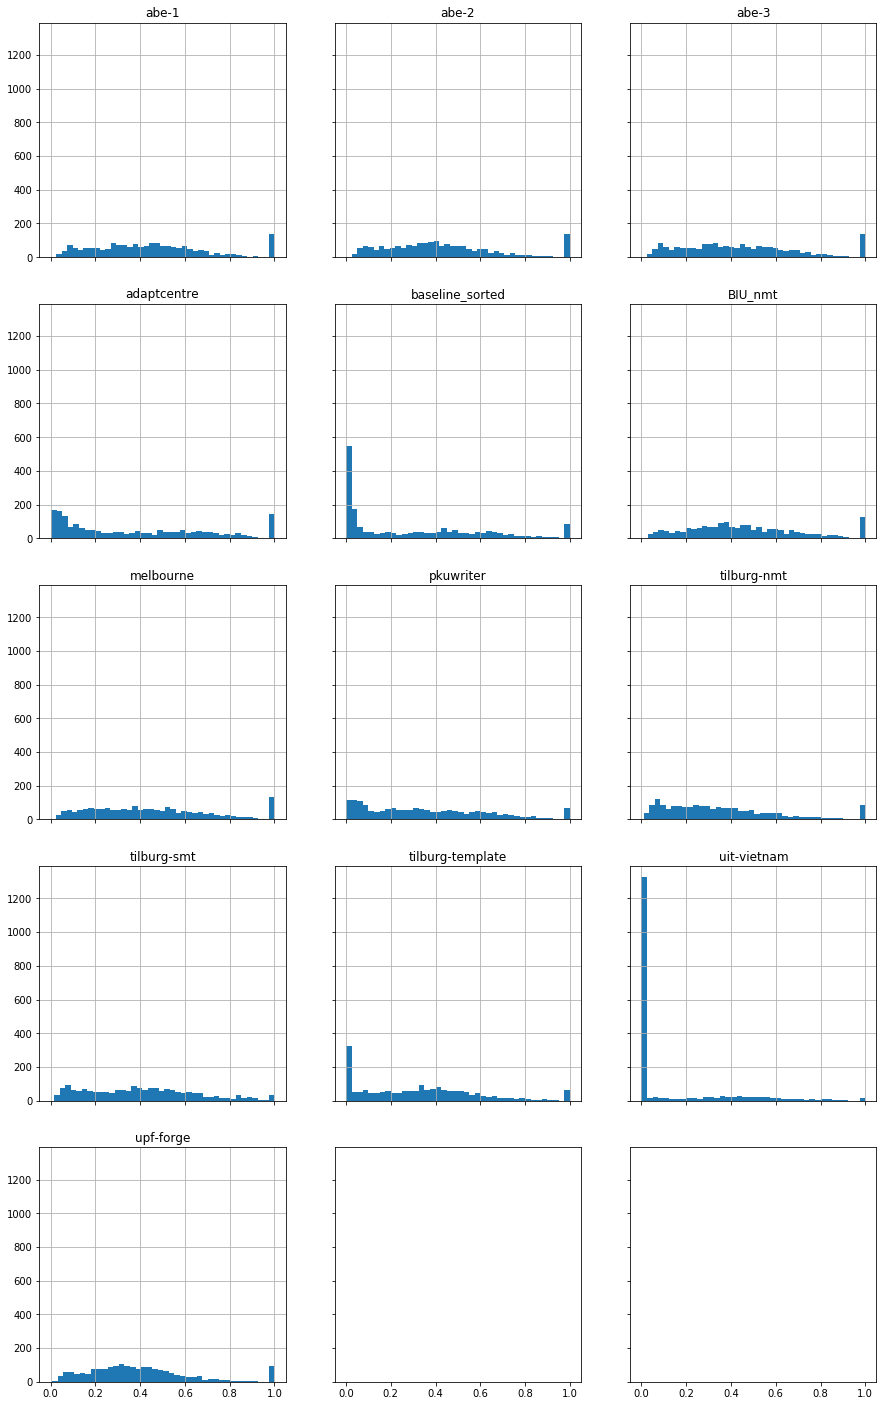

In [74]:
plot_all_models_hist_bleu('all-cat')

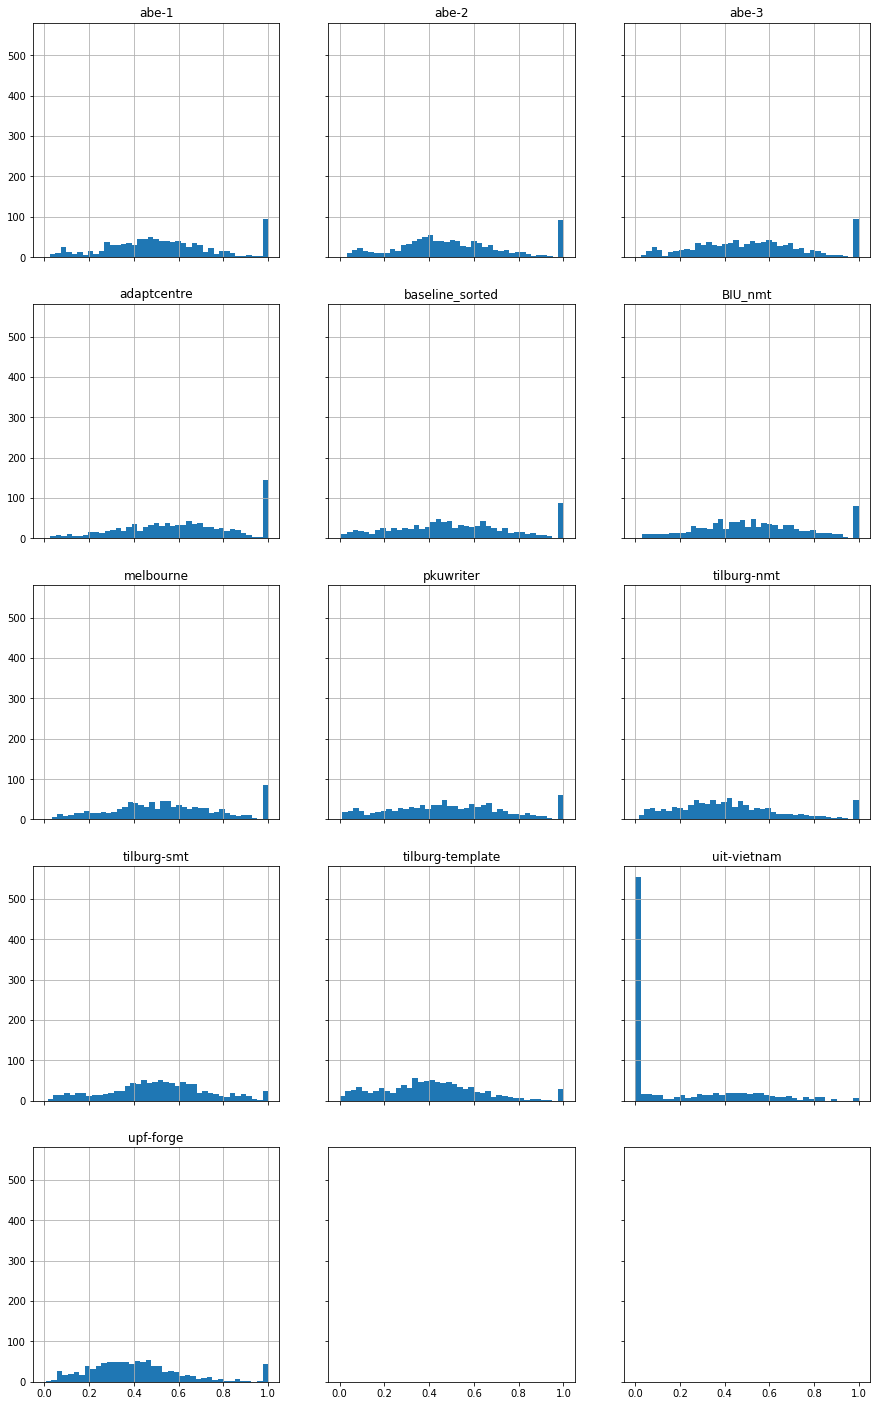

In [75]:
plot_all_models_hist_bleu('old-cat')

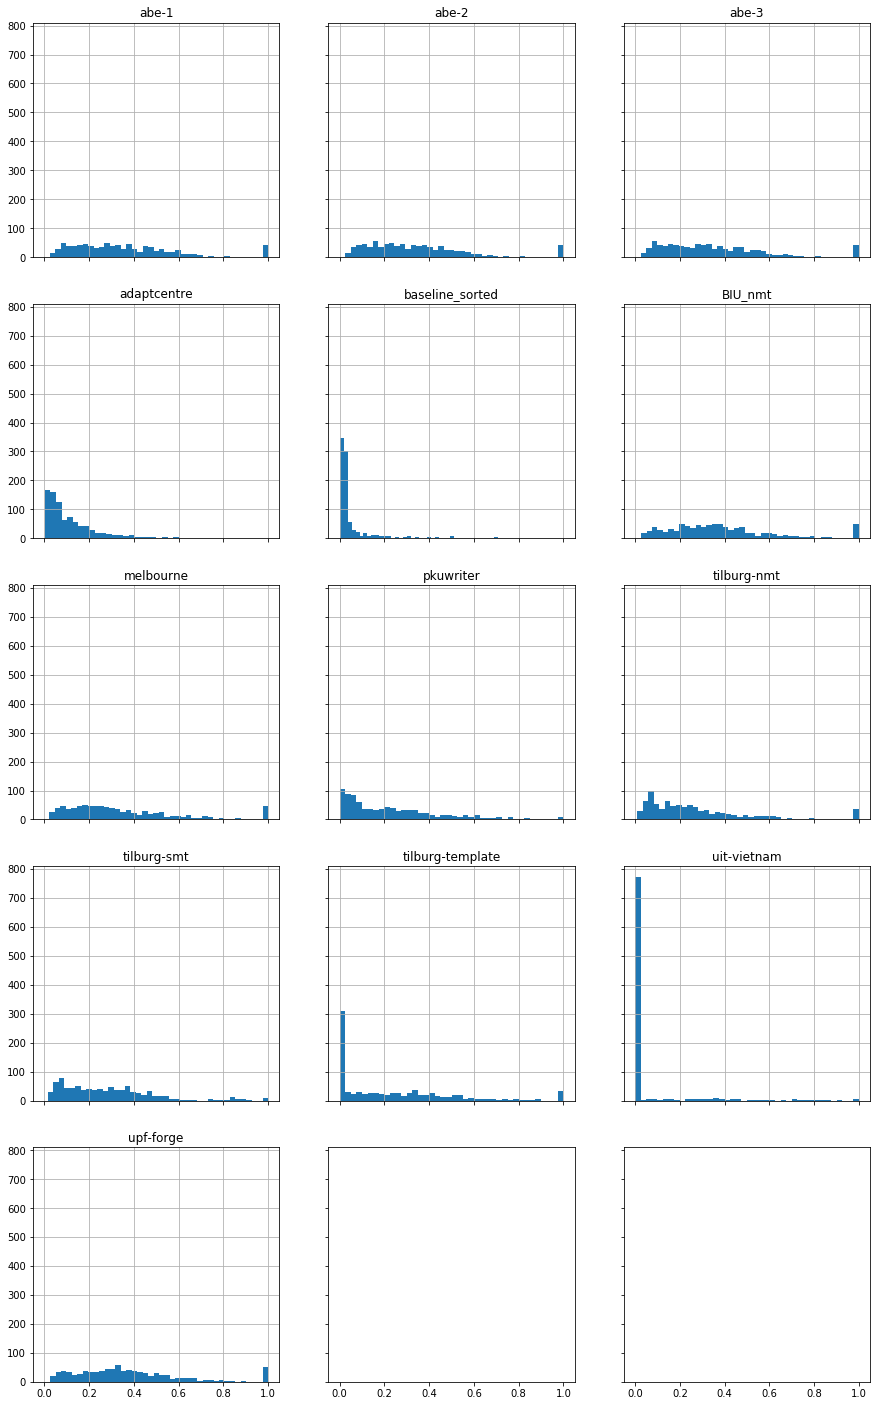

In [76]:
plot_all_models_hist_bleu('new-cat')

# Menores scores

In [85]:
scores, hypothesis, references = get_scores(model_preprocessed_filepath('adaptcentre', 'old-cat'), 'old-cat')
sorted_scores = sorted([(i, s) for i, s in enumerate(scores)], key=lambda v: v[1])

scores_a, hypothesis_a, references = get_scores(model_preprocessed_filepath('abe-3', 'old-cat'), 'old-cat')
sorted_scores_a = sorted([(i, s) for i, s in enumerate(scores_a)], key=lambda v: v[1])

In [103]:
import pandas as pd

pd.set_option('display.max_colwidth', 1000)

df = pd.DataFrame({'adaptcentre': scores, 'abe-3': scores_a, 'adaptcentre_texts': hypothesis, 'abe-3_texts': hypothesis_a})

df.head()

,abe-3,abe-3_texts,adaptcentre,adaptcentre_texts
0,0.711967,abilene regional airport serves the city of abilene .,0.834995,"abilene regional airport serves the city of abilene , texas ."
1,1.000000,"adolfo suarez madrid - barajas airport is located in madrid , paracuellos de jarama , san sebastian de los reyes and alcobendas .",1.000000,"adolfo suarez madrid - barajas airport can be found in madrid , paracuellos de jarama , san sebastian de los reyes and alcobendas ."
2,0.750534,18l / 36r is the runway name of adolfo suarez madrid - barajas airport .,1.000000,the runway name of adolfo suarez madrid - barajas airport is 18l / 36r .
3,0.834452,the icao location identifier of afonso pena international airport is sbct .,0.391819,afonso pena international airport ' s icao location identifier is sbct .
4,1.000000,afonso pena international airport serves the city of curitiba .,1.000000,afonso pena international airport serves the city of curitiba .


In [104]:
df['winner'] = (df['abe-3'] > df.adaptcentre).map({True: 'abe-3', False: 'adaptcentre'})
df['dif'] = df['abe-3'] - df.adaptcentre
df.head()

,abe-3,abe-3_texts,adaptcentre,adaptcentre_texts,winner,dif
0,0.711967,abilene regional airport serves the city of abilene .,0.834995,"abilene regional airport serves the city of abilene , texas .",adaptcentre,-0.123028
1,1.000000,"adolfo suarez madrid - barajas airport is located in madrid , paracuellos de jarama , san sebastian de los reyes and alcobendas .",1.000000,"adolfo suarez madrid - barajas airport can be found in madrid , paracuellos de jarama , san sebastian de los reyes and alcobendas .",adaptcentre,0.000000
2,0.750534,18l / 36r is the runway name of adolfo suarez madrid - barajas airport .,1.000000,the runway name of adolfo suarez madrid - barajas airport is 18l / 36r .,adaptcentre,-0.249466
3,0.834452,the icao location identifier of afonso pena international airport is sbct .,0.391819,afonso pena international airport ' s icao location identifier is sbct .,abe-3,0.442633
4,1.000000,afonso pena international airport serves the city of curitiba .,1.000000,afonso pena international airport serves the city of curitiba .,adaptcentre,0.000000


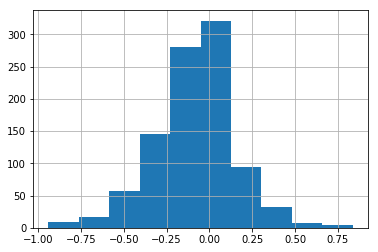

In [105]:
df.dif.hist()

In [112]:
df[df.dif < -0.5].sort_values('dif')

,abe-3,abe-3_texts,adaptcentre,adaptcentre_texts,winner,dif
86,0.061047,english is spoken in aenir .,1.000000,aenir is written in english .,adaptcentre,-0.938953
207,0.061645,cottage cheese is a variation of bionico .,1.000000,bionico can be varied by using cottage cheese .,adaptcentre,-0.938355
26,0.082348,danes inhabit denmark .,1.000000,the people of denmark are called danes .,adaptcentre,-0.917652
429,0.095189,the capitol of the united states is washington dc . one of the ethnic groups are native americans and the united states is also home to a severed wasp .,1.000000,a severed wasp is from the united states where the capital is washington dc and the native americans are an ethnic group .,adaptcentre,-0.904811
254,0.105696,from the the valencian community region in spain comes the traditional dish called arros negre .,1.000000,arros negre comes from the region of the valencian community in spain .,adaptcentre,-0.894304
251,0.105711,the language of italy is italian and arrabbiata sauce is located in italy .,1.000000,arrabbiata sauce is from italy where the italian language is spoken .,adaptcentre,-0.894289
192,0.147924,arros negre is from the the valencian community region .,1.000000,arros negre comes from the region of the valencian community .,adaptcentre,-0.852076
256,0.043995,from the malaysia region in indonesia comes the traditional dish called ayam penyet .,0.863340,ayam penyet is a popular dish in malaysia and indonesia .,adaptcentre,-0.819345
866,0.091623,"chicken is the main ingredient of fried chicken , which in turn is the main ingredient in ayam penyet . ayam penyet comes from both nationwide and also in malaysia and singapore and java ( where the ethnic group are the javenese people ) .",0.902514,"the fried chicken dish ayam penyet is made nationwide in java ( home of the javanese ) , and can also be found in malaysia and singapore .",adaptcentre,-0.810891
381,0.180149,"the company populous , designed 3arena , located on dublin .",0.923473,"the 3arena , designed by the company populous , is located in dublin .",adaptcentre,-0.743324


In [113]:
hypothesis[86], hypothesis_a[86]

('aenir is written in english .', 'english is spoken in aenir .')

In [110]:
references[26]

('denmark demonym is danes .',
 'the inhabitants of denmark have the demonym of danes .',
 'the people of denmark are called danes .')

In [90]:
s = 'abilene regional airport serves the city of abilene , texas .'
sentence_bleu([r.split() for r in references[0]], 
              s.split(), 
              smoothing_function=chencherry)

0.8349950232057651

In [81]:
s = 'the largest city in tarrant county in texas is fort worth . austin , texas is the capital of . arlington is part of tarrant county in . is part of texas . is in the united states .'
sentence_bleu([r.split() for r in references[810]], 
              s.split(), 
              smoothing_function=chencherry)

0.28102440992536304

# Avaliando com textos gerados pelo template

In [3]:
import pickle

with open('../data/models/abe-2/milhoes_de_textos', 'rb') as f:
    references = pickle.load(f)

In [4]:
import re

c = re.compile(r'\W')

In [12]:
def get_scores(filepath):
    
    hypothesis_file = filepath

    scores = []
    hypothesis = []

    with open(hypothesis_file, 'r', encoding='utf-8') as hyp:

        for h in hyp:
            hypothesis.append(h[:-1])

    for hyp, refs in zip(hypothesis, references):

        score = sentence_bleu([c.split(r) for r in refs], 
                              c.split(hyp), 
                              smoothing_function=chencherry)

        scores.append(score)
        
    return scores
    

def plot_hist_bleu(filepath, ax):

    scores = get_scores(filepath)
    
    s = pd.Series(scores)
    
    s.hist(ax=ax, bins=40)
    
def plot_all_models_hist_bleu(subset):
    
    models = [os.path.basename(s) for s in glob.glob('../data/models/*')]

    n_models = len(models)
    n_columns = 3
    n_rows = math.ceil(n_models / 3)

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 5*n_rows), sharey=True, sharex=True)

    for model, ax in zip(models, axes.ravel()):

        filepath = model_preprocessed_filepath(model, subset)

        plot_hist_bleu(filepath, ax)
        ax.set_title(model)

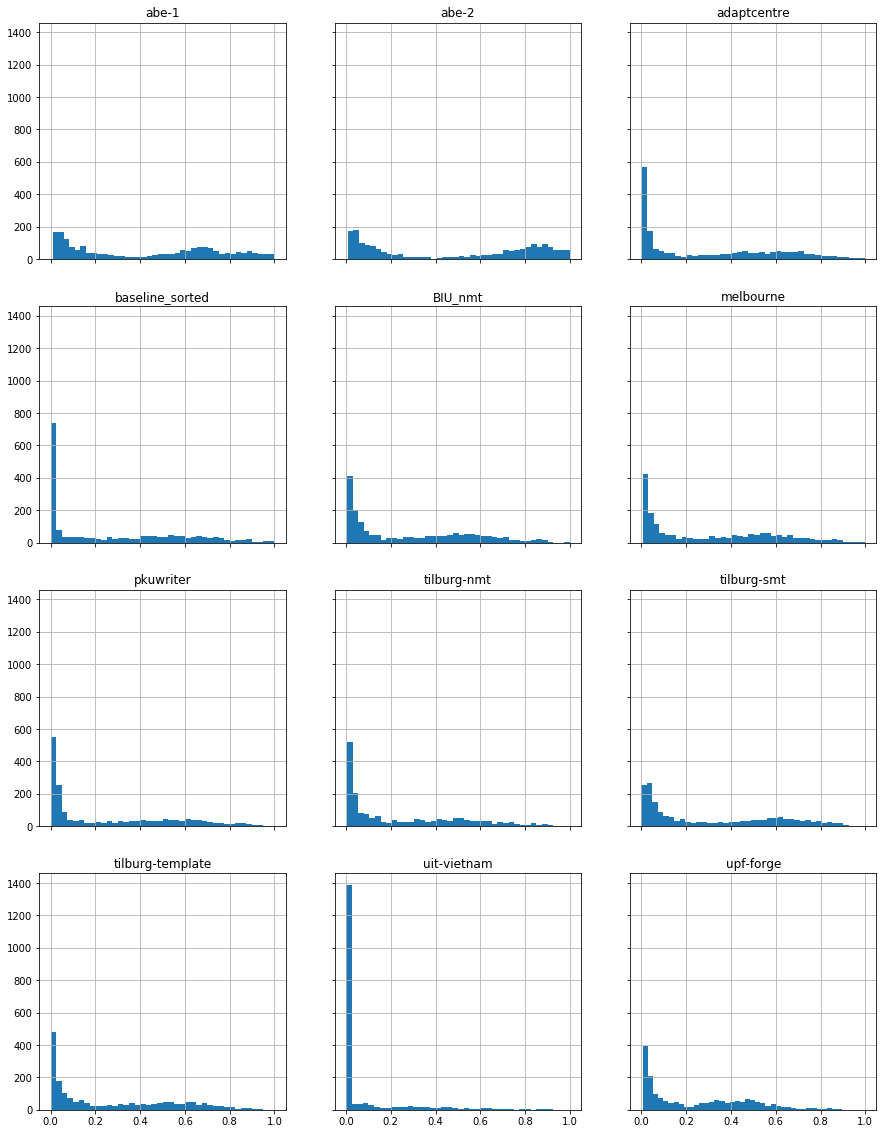

In [16]:
plot_all_models_hist_bleu('all-cat')